In [2]:
!pip install torch-geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 5.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910459 sha256=3994d5931674d00355cbad185829ed55a2ca5ca5cda2cb3139a40c31d7c58a5f
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch-geometric


In [3]:
from torch_geometric.datasets import Planetoid
import numpy as np
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


In [4]:
# 加载数据
dataset = Planetoid(root='.', name='Cora')
# dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of classes:\t\t",np.unique(data.y))
print("number of node features:\t",data.num_node_features)
print("number of edge features:\t",data.num_edge_features)
print("X shape: ", data.x.shape)
print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)


Processing...


Cora()
number of graphs:		 1
number of classes:		 7
number of classes:		 [0 1 2 3 4 5 6]
number of node features:	 1433
number of edge features:	 0
X shape:  torch.Size([2708, 1433])
Edge shape:  torch.Size([2, 10556])
Y shape:  torch.Size([2708])


Done!


In [5]:
# 搭建模型GCN
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16) # shape（输入的节点特征维度 * 中间隐藏层的维度）
        self.conv2 = GCNConv(16, dataset.num_classes) # shape（中间隐藏层的维度 * 节点类别）

    def forward(self, data):
        x, edge_index = data.x, data.edge_index # 加载节点特征和邻接关系

        x = self.conv1(x, edge_index) # 传入卷积层
        x = F.relu(x) # 激活函数
        x = F.dropout(x, training=self.training) # dropout层，防止过拟合
        x = self.conv2(x, edge_index) # 第二层卷积层

        # 将经过两层卷积得到的特征输入log_softmax函数得到概率分布
        return F.log_softmax(x, dim=1)


# 判断是否有GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载模型
model = GCN().to(device)
# 加载数据
data = dataset[0].to(device)
# 定义优化函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
num_epoch = 200
print(f'Graph Convolutional Network (GCN): \n{GCN()}') # 打印模型框架


Graph Convolutional Network (GCN): 
GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [6]:
#训练模型
model.train()
for epoch in range(num_epoch):
    optimizer.zero_grad() # 梯度清空为0
    out = model(data) # 模型输出
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask]) # 计算损失函数
    correct = (out.argmax(dim=1)[data.train_mask] == data.y[data.train_mask]).sum() # 计算正确的个数
    acc = int(correct) / int(data.train_mask.sum()) # 得出准确率
    loss.backward() # 反向传播计算梯度
    optimizer.step() # 利用梯度更新模型参数
    if (epoch+1) % 10 == 0:
        print('Epoch: {}, Loss: {:.4f}, Training Acc: {:.4f}'.format(epoch+1, loss.item(), acc))


Epoch: 10, Loss: 0.8674, Training Acc: 0.9214
Epoch: 20, Loss: 0.2643, Training Acc: 0.9500
Epoch: 30, Loss: 0.1064, Training Acc: 0.9786
Epoch: 40, Loss: 0.0660, Training Acc: 0.9929
Epoch: 50, Loss: 0.0524, Training Acc: 1.0000
Epoch: 60, Loss: 0.0419, Training Acc: 1.0000
Epoch: 70, Loss: 0.0505, Training Acc: 1.0000
Epoch: 80, Loss: 0.0267, Training Acc: 1.0000
Epoch: 90, Loss: 0.0511, Training Acc: 0.9929
Epoch: 100, Loss: 0.0351, Training Acc: 1.0000
Epoch: 110, Loss: 0.0503, Training Acc: 0.9929
Epoch: 120, Loss: 0.0301, Training Acc: 1.0000
Epoch: 130, Loss: 0.0441, Training Acc: 1.0000
Epoch: 140, Loss: 0.0331, Training Acc: 1.0000
Epoch: 150, Loss: 0.0322, Training Acc: 0.9929
Epoch: 160, Loss: 0.0389, Training Acc: 1.0000
Epoch: 170, Loss: 0.0279, Training Acc: 1.0000
Epoch: 180, Loss: 0.0248, Training Acc: 1.0000
Epoch: 190, Loss: 0.0258, Training Acc: 1.0000
Epoch: 200, Loss: 0.0285, Training Acc: 1.0000


In [7]:
# 评估模型
model.eval()
with torch.no_grad(): # 不记录梯度
    pred1 = model(data)
    pred = pred1.argmax(dim=1)  # 得到模型输出的类别
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum() # 计算正确的个数
    acc = int(correct) / int(data.test_mask.sum()) # 得出准确率
    f1 = f1_score(pred[data.test_mask].cpu(), data.y[data.test_mask].cpu(), average='macro') #计算F1分数
    print(f'Accuracy: {acc:.4f}',f'F1_score: {f1:.4f}')
# 宏平均 Macro-average
# Macro F1：将n分类的评价拆成n个二分类的评价，计算每个二分类的F1 score，n个F1 score的平均值即为Macro F1。
# 微平均 Micro-average
# Micro F1：将n分类的评价拆成n个二分类的评价，将n个二分类评价的TP、FP、TN、FN对应相加，计算评价准确率和召回率，由这2个准确率和召回率计算的F1 score即为Micro F1。


Accuracy: 0.8060 F1_score: 0.8009


7


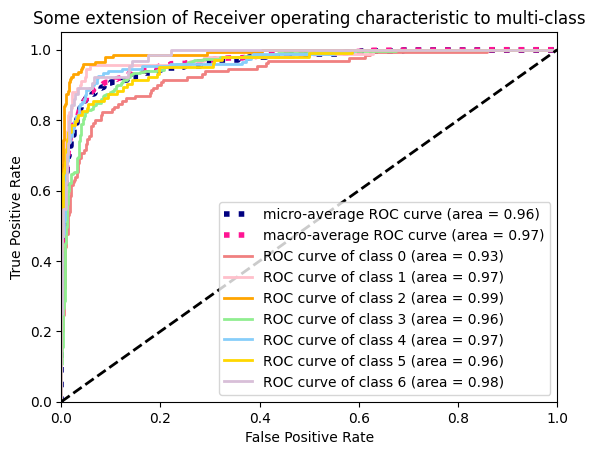

In [9]:
# 绘制ROC曲线
# ROC曲线：
# 横坐标：假正率（False positive rate，FPR），预测为正但实际为负的样本占所有负例样本的比例；
# FPR = FP / (FP +TN)   
# 纵坐标：真正率（True positive rate，TPR），这个其实就是召回率，预测为正且实际为正的样本占所有正例样本的比例。
# TPR = TP / (TP+ FN) 
# AUC：就是ROC曲线和横坐标围成的面积。
y_test = label_binarize(data.y[data.test_mask].cpu(),classes=[0,1,2,3,4,5,6]) # 将标签二值化
y_score = pred1[data.test_mask].cpu().detach().numpy()
# 设置种类
n_classes = y_test.shape[1]
print(n_classes)
# 计算每一类的ROC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i],tpr[i],_ = roc_curve(y_test[:,i],y_score[:,i])
    roc_auc[i] = auc(fpr[i],tpr[i])
# 计算微平均ROC曲线和AUC（方法二）
fpr['micro'],tpr['micro'],_ = roc_curve(y_test.ravel(),y_score.ravel())
roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])
# 计算宏平均ROC曲线和AUC（方法一）
# 首先汇总所有FPR
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# 然后再用这些点对ROC曲线进行插值
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# 最后求平均并计算AUC
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# 绘制所有ROC曲线
lw=2
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='deeppink', linestyle=':', linewidth=4)

colors = ['lightcoral', 'pink', 'orange', 'lightgreen', 'lightskyblue', 'gold', 'thistle']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# 打印 model's state_dict
#print("Model's state_dict:")
#for param_tensor in model.state_dict():
#    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# 打印 optimizer's state_dict
#print("Optimizer's state_dict:")
#for var_name in optimizer.state_dict():
#    print(var_name, "\t", optimizer.state_dict()[var_name])

# 保存模型参数
#torch.save(model.state_dict(), "Parameter/GCNCora.pkl")